c:\Python312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


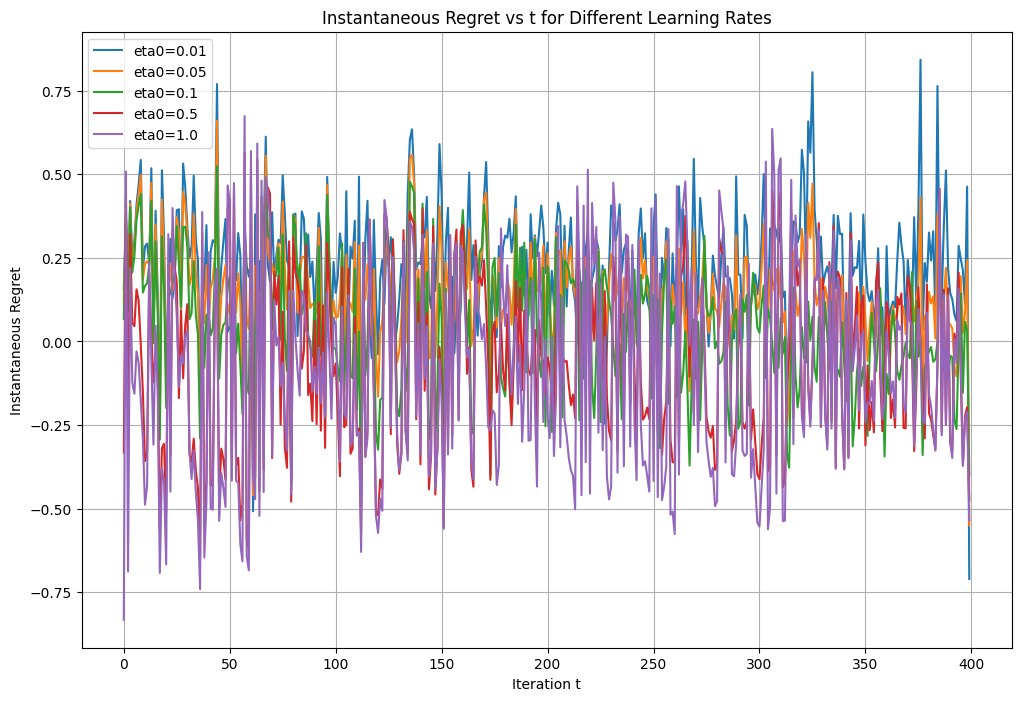

Initial learning rate 0.01: Total Regret = 92.4055
Initial learning rate 0.05: Total Regret = 57.9082
Initial learning rate 0.1: Total Regret = 16.5523
Initial learning rate 0.5: Total Regret = -24.9869
Initial learning rate 1.0: Total Regret = -37.4886


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv("C:/Users/frion/Downloads/toydata_small.csv")
X = data[["x1", "x2", "x3", "x4"]].values
y = data["y"].values

# Normalize features
X = X / np.linalg.norm(X, axis=1, keepdims=True)

# Shuffle data
np.random.seed(42)
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

# Parameters
T = len(X)
learning_rates = [0.01, 0.05, 0.1, 0.5, 1.0]

# Hinge loss
def hinge_loss(w, x, y):
    return max(0, 1 - y * np.dot(w, x))

# Subgradient of hinge loss
def subgradient(w, x, y):
    if y * np.dot(w, x) < 1:
        return -y * x
    return np.zeros_like(w)

# Projection onto L2 ball
def project_onto_l2_ball(w, radius=1.0):
    norm = np.linalg.norm(w)
    return w if norm <= radius else (w / norm)

# Store results
regrets = {}
instantaneous_regrets = {}

# Optimal w* (offline solution)
def compute_optimal_w(X, y):
    from sklearn.svm import LinearSVC
    clf = LinearSVC(C=1e6, loss='hinge', fit_intercept=False, max_iter=10000)
    clf.fit(X, y)
    w_star = clf.coef_[0]
    return project_onto_l2_ball(w_star)

w_star = compute_optimal_w(X, y)

for eta0 in learning_rates:
    w = np.zeros(X.shape[1])
    regrets_list = []
    instant_regret = []
    
    for t in range(1, T + 1):
        eta = eta0 / np.sqrt(t)  # Annealed learning rate
        x_t, y_t = X[t - 1], y[t - 1]
        grad = subgradient(w, x_t, y_t)
        w = w - eta * grad
        w = project_onto_l2_ball(w)

        loss_wt = hinge_loss(w, x_t, y_t)
        loss_ws = hinge_loss(w_star, x_t, y_t)
        instant_regret.append(loss_wt - loss_ws)

    regrets[eta0] = np.sum(instant_regret)
    instantaneous_regrets[eta0] = instant_regret

# Plot instantaneous regret
plt.figure(figsize=(12, 8))
for eta0 in learning_rates:
    plt.plot(instantaneous_regrets[eta0], label=f"eta0={eta0}")
plt.xlabel("Iteration t")
plt.ylabel("Instantaneous Regret")
plt.title("Instantaneous Regret vs t for Different Learning Rates")
plt.legend()
plt.grid(True)
plt.show()

# Report cumulative regret
for eta0 in learning_rates:
    print(f"Initial learning rate {eta0}: Total Regret = {regrets[eta0]:.4f}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      400 non-null    float64
 1   x2      400 non-null    float64
 2   x3      400 non-null    float64
 3   x4      400 non-null    float64
 4   y       400 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 15.8 KB


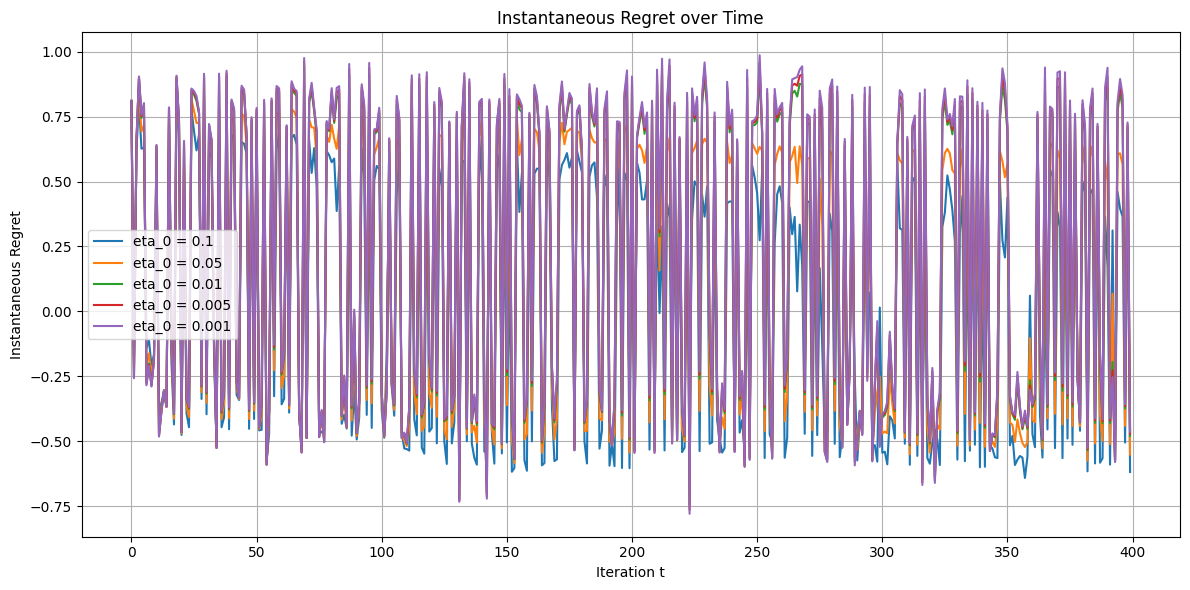

{0.1: 5.0504822815461345,
 0.05: 45.69650155093865,
 0.01: 80.03779484533932,
 0.005: 84.3304565071394,
 0.001: 87.76458583657947}

In [3]:
# Task 2: Online SVM with Hinge Loss – Implementation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier

# Load the dataset
file_path = r"C:\Users\frion\Downloads\toydata_small.csv"
df = pd.read_csv(file_path)

# Display dataset info and head
df.info()
df.head()

# Prepare the data
X = df[['x1', 'x2', 'x3', 'x4']].values
y = df['y'].values

# Normalize the feature vectors
X = X / np.linalg.norm(X, axis=1, keepdims=True)

# Parameters
T = len(y)
initial_learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001]
norm_bound = 1.0  # for projection onto L2 ball

# Hinge loss
def hinge_loss(w, x, y):
    return max(0, 1 - y * np.dot(w, x))

# Subgradient of hinge loss
def hinge_subgradient(w, x, y):
    return -y * x if y * np.dot(w, x) < 1 else np.zeros_like(w)

# Project w onto L2 norm ball
def project_onto_l2_ball(w, radius=1.0):
    norm = np.linalg.norm(w)
    return w if norm <= radius else (w / norm) * radius

# Offline optimal solution (approximate with batch SVM)
clf = SGDClassifier(loss='hinge', alpha=1e-6, max_iter=1000, tol=1e-3)
clf.fit(X, y)
w_star = clf.coef_[0]
w_star = project_onto_l2_ball(w_star, norm_bound)

# Online SVM Loop
results = {}

for eta_0 in initial_learning_rates:
    w = np.zeros(4)
    regrets = []

    for t in range(T):
        eta_t = eta_0 / np.sqrt(t + 1)  # annealing schedule

        # Current sample
        x_t = X[t]
        y_t = y[t]

        # Compute losses
        loss_t_w = hinge_loss(w, x_t, y_t)
        loss_t_w_star = hinge_loss(w_star, x_t, y_t)
        regrets.append(loss_t_w - loss_t_w_star)

        # Update weight vector
        subgrad = hinge_subgradient(w, x_t, y_t)
        w = w - eta_t * subgrad

        # Project onto feasible set
        w = project_onto_l2_ball(w, norm_bound)

    results[eta_0] = regrets

# Plot instantaneous regrets
plt.figure(figsize=(12, 6))
for eta_0, regrets in results.items():
    plt.plot(regrets, label=f'eta_0 = {eta_0}')
plt.title('Instantaneous Regret over Time')
plt.xlabel('Iteration t')
plt.ylabel('Instantaneous Regret')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Compute total regrets
total_regrets = {eta: np.sum(regret) for eta, regret in results.items()}
total_regrets


In [4]:
import numpy as np

def project_onto_l1_ball(v, z=1.0):
    """Projects a vector v onto the L1-ball of radius z."""
    if np.linalg.norm(v, 1) <= z:
        return v

    u = np.abs(v)
    if np.sum(u) == 0:
        return v

    # Sort u in descending order
    sorted_u = np.sort(u)[::-1]
    cssv = np.cumsum(sorted_u)
    rho = np.nonzero(sorted_u * np.arange(1, len(v)+1) > (cssv - z))[0][-1]
    theta = (cssv[rho] - z) / (rho + 1)
    w = np.sign(v) * np.maximum(u - theta, 0)
    return w


In [5]:
# (c) Projection in 2D
point = np.array([2.0, 1.0])

# Projection onto L1-ball
proj_l1 = project_onto_l1_ball(point)

# Projection onto L2-ball
def project_onto_l2_ball(v, radius=1.0):
    norm = np.linalg.norm(v, 2)
    return v if norm <= radius else v * radius / norm

proj_l2 = project_onto_l2_ball(point)

print("Original point:      ", point)
print("L1 projection:       ", proj_l1)
print("L2 projection:       ", proj_l2)


Original point:       [2. 1.]
L1 projection:        [1. 0.]
L2 projection:        [0.89442719 0.4472136 ]
